# Resnet 18 on faces 

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import random
import resnet


In [2]:
batchsize = 75
rate = 0.15
epochs = 150
lr_decay = 0.84
lr_stride = 5

In [3]:
class FaceDataset(torch.utils.data.Dataset):

    def __init__(self, transform, train=True):
        self.image_prefix = "face_renders/face"
        self.image_suffix = ".jpg"
        self.vertex_prefix = "processed_faces/face"
        self.vertex_suffix = ".txt"
        self.count = 5000
        self.trainn = 4500
        
        self.train = train
        self.transform = transform
        
        shape = np.loadtxt(self.vertex_prefix + str(1) + self.vertex_suffix).shape
        tmp = np.zeros((self.count, shape[0], shape[1]))
        for i in range(self.count):
            tmp[i] = np.loadtxt(self.vertex_prefix + str(i + 1) + self.vertex_suffix)
            
        self.mean = np.mean(tmp, axis=0)
        self.outputdim = shape[0] * shape[1]
        self.labels = [torch.from_numpy((lab - self.mean).reshape(self.outputdim)).float() for lab in tmp]
        
        self.images = [plt.imread(self.image_prefix + str(i + 1) + self.image_suffix) for i in range(self.count)]
            
        # simple version for working with CWD
        

    def __len__(self):
        if self.train:
            return self.trainn
        else:
            return self.count - self.trainn

    def __getitem__(self, idx):
        if not self.train:
            idx += self.trainn
        return (self.transform(self.images[idx]), self.labels[idx])

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = FaceDataset(transform, train=True)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchsize,
                                          shuffle=True, num_workers=0)

testset = FaceDataset(transform, train=False)
testloader = torch.utils.data.DataLoader(testset, batch_size=batchsize,
                                          shuffle=False, num_workers=0)


In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("torch.cuda.is_available()   =", torch.cuda.is_available())
print("torch.cuda.device_count()   =", torch.cuda.device_count())
print("torch.cuda.device('cuda')   =", torch.cuda.device(0))
print("torch.cuda.current_device() =", torch.cuda.current_device())

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
    
    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)
    
    def __len__(self):
        return len(self.dl)
    
trainloader = DeviceDataLoader(trainloader, device)
testloader = DeviceDataLoader(testloader, device)

torch.cuda.is_available()   = True
torch.cuda.device_count()   = 1
torch.cuda.device('cuda')   = <torch.cuda.device object at 0x0000019D7A45EE10>
torch.cuda.current_device() = 0


In [18]:
model = resnet.resnet18(output_size=trainset.outputdim)
model.to(device)
#optimizer = optim.SGD(model.parameters(), lr=rate)
#optimizer = optim.Adam(model.parameters(), lr=rate)
optimizer = optim.SGD(model.parameters(), lr=rate, momentum=0.95)

criterion = nn.MSELoss()

def adjust_learning_rate(optimizer, epoch, decay, stride):
    lr = rate * (decay ** (epoch // stride))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr


In [19]:
def train(model, optimizer, criterion, epochs, trainloader, testloader):
    model.train()
    samples = 1
    losses = []
    test_losses = []
    k = len(trainloader)// samples
    
    for epoch in range(epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % k == k - 1:

                losses.append(running_loss / k)
                
                testloss = 0
                total = 0
                iterations = 0
                with torch.no_grad():
                    for data in testloader:
                        images, labels = data
                        outputs = model(images)
                        testloss += criterion(outputs, labels)
                        total += labels.size(0)
                        iterations += 1
                        if total > 200:
                            break
                test_losses.append(testloss / iterations)
                
                print('[%d, %5d] loss: %.3f test_loss: %.3f' %(epoch + 1, i + 1,losses[-1], test_losses[-1]))

                running_loss = 0.0
                
        adjust_learning_rate(optimizer, epoch+1, lr_decay, lr_stride)

    print('Finished Training')
    plt.plot(np.arange(0, len(losses)/samples, 1.0/samples), losses)
    plt.title("loss")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.show()
    
    plt.plot(np.arange(0, len(test_losses)/samples, 1.0/samples), test_losses)
    plt.title("test_loss")
    plt.xlabel("epoch")
    plt.ylabel("test_losses")
    plt.show()
    model.eval()


[1,    60] loss: 7.306 test_loss: 5.625
[2,    60] loss: 5.029 test_loss: 4.915
[3,    60] loss: 4.577 test_loss: 4.466
[4,    60] loss: 4.170 test_loss: 4.125
[5,    60] loss: 3.817 test_loss: 3.933
[6,    60] loss: 3.526 test_loss: 3.733
[7,    60] loss: 3.362 test_loss: 3.611
[8,    60] loss: 3.235 test_loss: 3.522
[9,    60] loss: 3.123 test_loss: 3.416
[10,    60] loss: 3.076 test_loss: 3.353
[11,    60] loss: 2.882 test_loss: 3.217
[12,    60] loss: 2.762 test_loss: 3.201
[13,    60] loss: 2.713 test_loss: 3.248
[14,    60] loss: 2.673 test_loss: 3.150
[15,    60] loss: 2.566 test_loss: 3.113
[16,    60] loss: 2.495 test_loss: 3.103
[17,    60] loss: 2.355 test_loss: 2.961
[18,    60] loss: 2.260 test_loss: 2.934
[19,    60] loss: 2.215 test_loss: 2.981
[20,    60] loss: 2.139 test_loss: 2.991
[21,    60] loss: 2.064 test_loss: 2.962
[22,    60] loss: 1.977 test_loss: 2.791
[23,    60] loss: 1.897 test_loss: 2.838
[24,    60] loss: 1.826 test_loss: 2.707
[25,    60] loss: 1.792 t

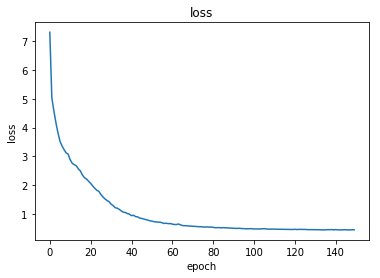

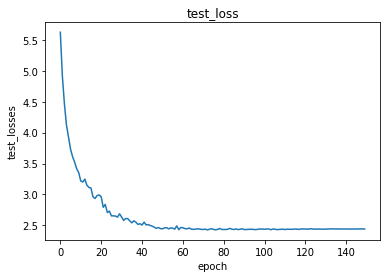

In [20]:
train(model, optimizer, criterion, epochs, trainloader, testloader)

In [21]:
torch.save(model.state_dict(), "res18b" + str(batchsize) + "r" + str(rate) + "e" + str(epochs) + ".statedict")

In [ ]:
with torch.no_grad():
    d = next(testloader.__iter__())
    images, labels = d
    outputs = model(images)
    
    print(trainset.mean)
    print(outputs[0])
    print(labels[0])
    print(np.linalg.norm((labels[0] - outputs[0]).to('cpu').numpy()))
    

In [ ]:
np.mean(np.std([l.numpy() for l in trainset.labels], axis=0))

In [5]:
model = resnet.resnet101(output_size=trainset.outputdim)
model.load_state_dict(torch.load("res101b75r0.15e150.statedict"))
model.to(device)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [6]:
running_loss = 0
criterion = nn.MSELoss()
start = 4501
for i, data in enumerate(testloader, 0):
    # get the inputs
    inputs, labels = data

    # forward + backward + optimize
    outputs = model(inputs)
    
    for o in outputs:
        arr = o.detach().to("cpu").numpy().reshape((564,3)) + testset.mean
        
        np.savetxt("res50predictions/face" + str(start) + ".txt", arr, fmt="%.9f")
        start += 1
    
    loss = criterion(outputs, labels)

    # print statistics
    running_loss += loss.item() * len(outputs)
    
print(running_loss / 500 * trainset.outputdim)

4894.820931386947


In [ ]:
print (len(testloader))

In [ ]:
output = model(testset.transform(plt.imread("real/IMG_3368_cropped.png")[:,:,:3]).unsqueeze(0))
output = output.detach().to("cpu").numpy().reshape((564,3)) + testset.mean
np.savetxt("res101predictions/facecustom.txt", output, fmt="%.9f")